# Filtering large-scale volumes

This notebook describes how to **process large-scale volumes**, addressing how to

- **Avoid running out of memory**
- **Interactively select, apply, and optimize parameters on a region of interest**
- **Process the volume in parallel**

There are three sections addressing,

1. How to
    - Pre-compute the chunked, multiscale volumetric pyramid
    - Interactively select a region of interest (ROI) and data scale
    - Interactively apply the filter, inspect the results, and optimize parameters
    - Apply the filter over the entire, multiscale volume
2. Apply algorithms categories that require
    1. Only the pixel value
    2. A known domain around a pixel
    3. An extended information context
3. Examples with a few common filters



In [1]:
import itk
from ngff_zarr import ngff_image_to_itk_image, to_ngff_zarr, itk_image_to_ngff_image, to_multiscales, to_ngff_zarr, Methods, from_ngff_zarr
from itkwidgets import view
import zarr
from rich import print
import ipywidgets as widgets
import dask.array as da
import numpy as np
from copy import copy
import dask_image.ndmeasure

## Pre-compute the chunked, multiscale volumetric pyramid

Internally, `itkwidgets` will generate an in-memory chunked, multiscale [OME-Zarr](https://ngff.openmicroscopy.org/latest/) for interactive visualization of the volume.

When working with large datasets, the compressed, chunked, multiscale representation can be pre-generated without loading the volume into memory. For more information, see [ngff-zarr](https://ngff-zarr.readthedocs.io/en/latest/). 

In [2]:
itk_image = itk.imread("./turkey_vulture_skull_small.tif")
ngff_image = itk_image_to_ngff_image(itk_image)

For `Methods.ITK_GAUSSIAN` support,

```sh
pip install "ngff-zarr[itk]"
```

To add GPU acceleration,

```sh
pip install itk-vkfft
```

There are also [methods appropriate for label images](https://ngff-zarr.readthedocs.io/en/latest/methods.html).

In [3]:
multiscales = to_multiscales(ngff_image, method=Methods.ITK_GAUSSIAN)
# dimension_separator="/" is required for OME-Zarr. It also improves filesystem usage for large datasets.
zarr_store = zarr.DirectoryStore("./turkey_vulture_skull_small.zarr", dimension_separator="/")
to_ngff_zarr(zarr_store, multiscales)

In [4]:
image = zarr.open(zarr_store)


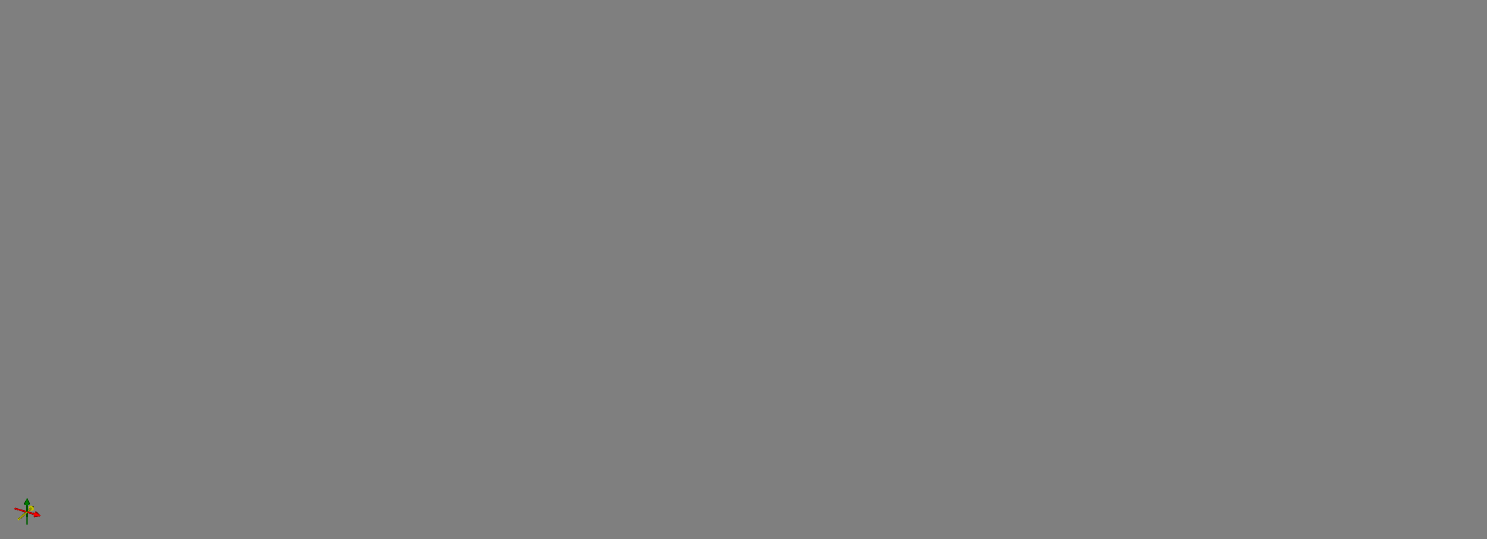
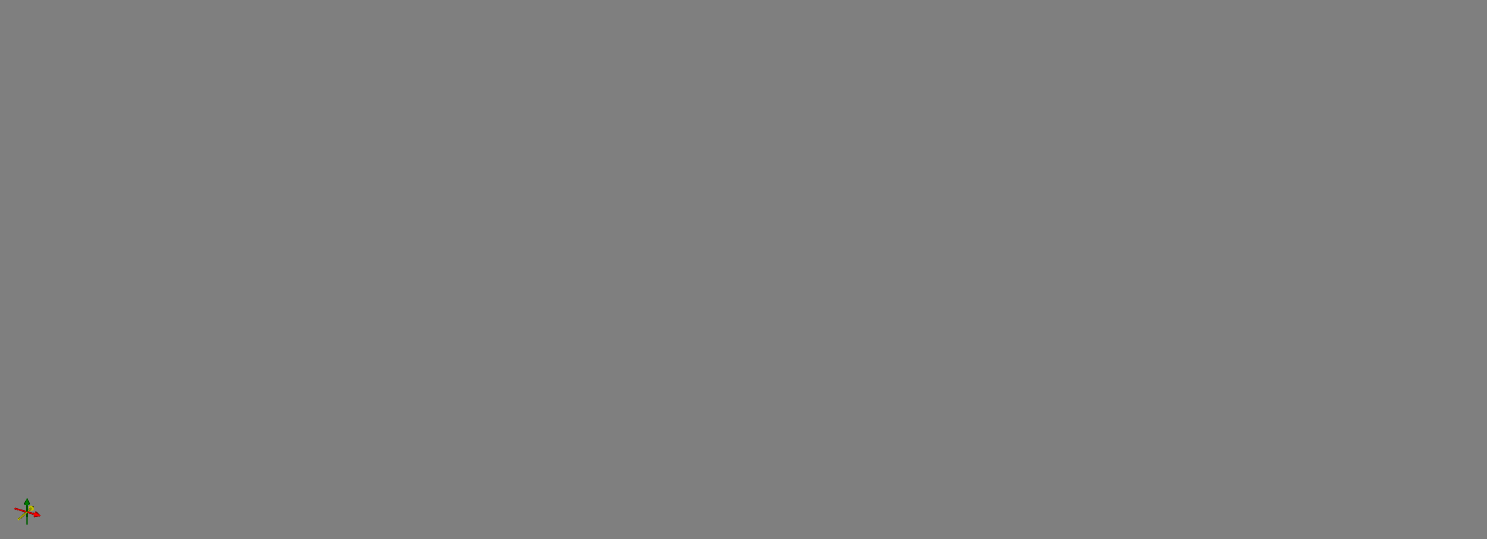

<IPython.core.display.Javascript object>

In [5]:
viewer = view(image)

## Interactively select a region of interest (ROI) and data scale

#### There will be one or more resolution scales available depending on the size of the data. The lower the scale the higher the resolution, with zero being the highest resolution.

Use the region of interest **cropping planes interface** in the viewer to optionally select a sub-region of interest and explore the impact of filtering on this region.

In [6]:
# Find the scale that we currently have loaded
loaded_scale = viewer.get_current_scale()

In [7]:
loaded_scale

1

#### By default the information for the current scale is returned when requesting the ROI slices. You can also pass a value in to explicitly request a scale.

In [8]:
# Request the slice information for the ROI
default_roi_slices = viewer.get_roi_slice()
roi_slices = viewer.get_roi_slice(loaded_scale)

#### The results should match!
#### *Note*: The data is streamed in in chunks and the current resolution will improve as each scale becomes available. If you find that the slices do not match check the currently loaded scale (either programmatically or with the UI) - it may have improved since you last checked!

In [9]:
# The results should match
print(f'Slices for loaded scale:       {roi_slices}')
print(f'Slices with default parameter: {default_roi_slices}')

Slices for loaded scale:       (slice(0, 221, None), slice(0, 239, None), slice(0, 211, None))

Slices with default parameter: (slice(0, 221, None), slice(0, 239, None), slice(0, 211, None))

#### The ROI region will return the physical, world coordinates for the selection

In [10]:
# Get the selected region for the current level
roi_region = viewer.get_roi_region()

In [11]:
print(roi_region)

[{'x': -0.5, 'y': -0.5, 'z': -0.5}, {'x': 421.5, 'y': 477.5, 'z': 220.5}]

In [12]:
# get_roi_image will return an ngff image for the currently selected image
# optionally a name can also be passed in to select a specific image if more than one image or label is loaded
roi_image = viewer.get_roi_image(loaded_scale)

In [13]:
print(roi_image)

NgffImage(
    data=dask.array<from-zarr, shape=(221, 239, 211), dtype=uint8, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
    dims=['z', 'y', 'x'],
    scale={'z': 1.0, 'y': 2.0, 'x': 2.0},
    translation={'x': -0.5, 'y': -0.5, 'z': -0.5},
    name='Image',
    axes_units={'z': None, 'y': None, 'x': None},
    computed_callbacks=[]
)

In [14]:
# Optionally we can also grab the ngff images for all scales
roi_multiscales = viewer.get_roi_multiscale()

In [15]:
print(roi_multiscales)

Multiscales(
    images=[
        NgffImage(
            data=dask.array<from-zarr, shape=(221, 479, 423), dtype=uint8, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=['z', 'y', 'x'],
            scale={'z': 1.0, 'y': 1.0, 'x': 1.0},
            translation={'x': -0.5, 'y': -0.5, 'z': -0.5},
            name='Image',
            axes_units={'z': None, 'y': None, 'x': None},
            computed_callbacks=[]
        ),
        NgffImage(
            data=dask.array<from-zarr, shape=(221, 239, 211), dtype=uint8, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=['z', 'y', 'x'],
            scale={'z': 1.0, 'y': 2.0, 'x': 2.0},
            translation={'x': -0.5, 'y': -0.5, 'z': -0.5},
            name='Image',
            axes_units={'z': None, 'y': None, 'x': None},
            computed_callbacks=[]
        )
    ],
    metadata=Metadata(
        axes=[
            Axis(name='z', type='space', unit=None),
            Axis(name='y', type='space', unit=None),
            Axis(name='x', type='space', unit=None)
        ],
        datasets=[
            Dataset(
                path='scale0/image',
                coordinateTransformations=[
                    Scale(scale=[1.0, 1.0, 1.0], type='scale'),
                    Translation(translation=[0.0, 0.0, 0.0], type='translation')
                ]
            ),
            Dataset(
                path='scale1/image',
                coordinateTransformations=[
                    Scale(scale=[1.0, 2.0, 2.0], type='scale'),
                    Translation(translation=[0.0, 0.5, 0.5], type='translation')
                ]
            )
        ],
        coordinateTransformations=None,
        name='image',
        version='0.4'
    ),
    scale_factors=None,
    method=None,
    chunks=None
)

## Interactively apply the filter, inspect the results, and optimize parameters

Let's apply a simple ITK filter, a threshold.


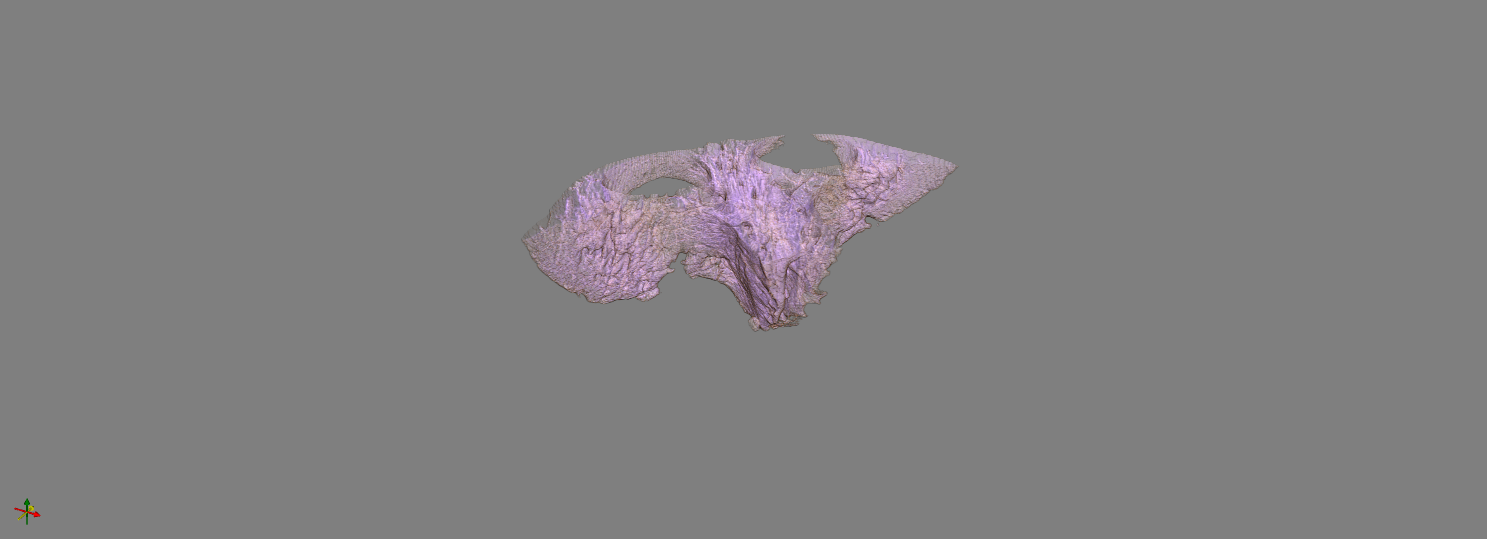
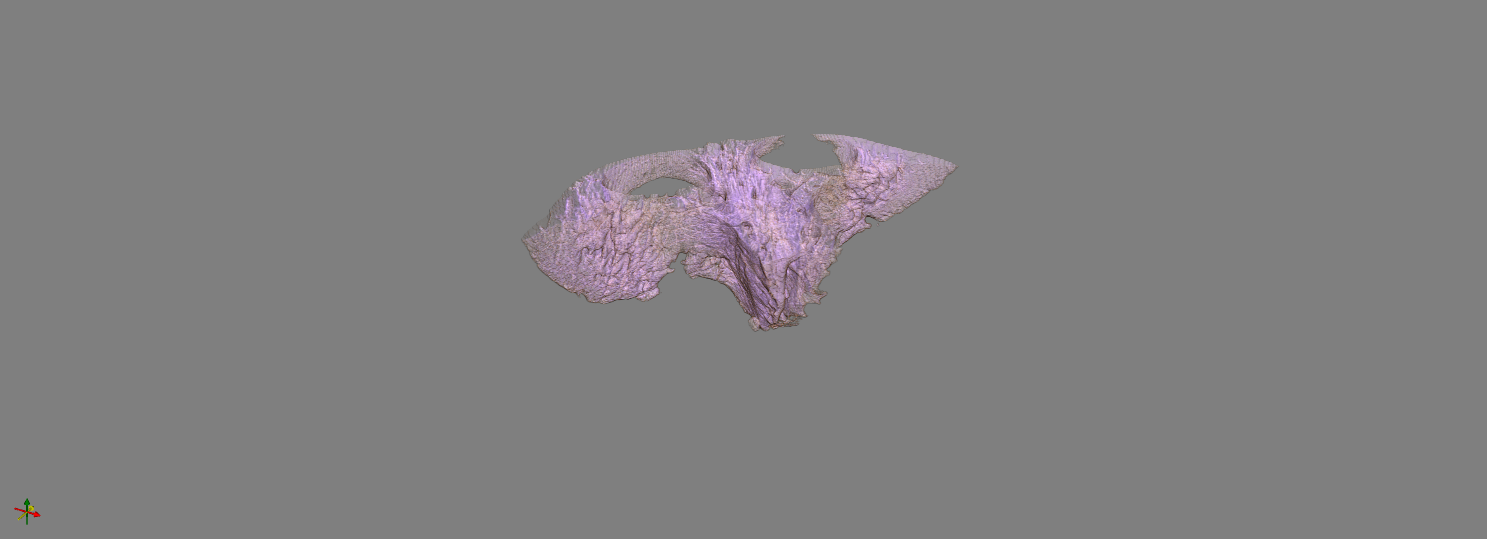

<IPython.core.display.Javascript object>

In [16]:
# Preserves spatial metadata
itk_image = ngff_image_to_itk_image(roi_image, wasm=False)
# Retain pixels greater than 128
thresholded = itk.threshold_image_filter(itk_image, lower=128)

viewer = view(image=thresholded)

We can interactively optimize parameters with [Jupyter Widgets](https://ipywidgets.readthedocs.io/).

In [17]:
slider = widgets.IntSlider(value=128, min=0, max=255, description='threshold')

def on_threshold_change(change):
    threshold = change['new']
    thresholded = itk.binary_threshold_image_filter(itk_image, lower_threshold=threshold)
    viewer.set_image(thresholded)
slider.observe(on_threshold_change, names='value')

slider

IntSlider(value=128, description='threshold', max=255)

## Apply the filter over the entire, multiscale volume

At a given scale, the pixel data is comprised of chunks. When processed with [dask](https://dask.org), these charged can be loaded into memory when needed.

In [18]:
roi_image.data

dask.array<from-zarr, shape=(221, 239, 211), dtype=uint8, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

To apply a filter to the chunks, we can use [dask.array.map_blocks](https://docs.dask.org/en/stable/generated/dask.array.map_blocks.html).

In [19]:
def apply_threshold(image_data, threshold=128):
    # import itk in the function due to details of how dask distributes processing
    import itk
    
    result = itk.binary_threshold_image_filter(image_data, lower_threshold=threshold)
    
    # convert to a numpy ndarray
    return np.asarray(result).copy()

threshold = 80

full_res = roi_multiscales.images[0]

# The first argument passed to apply_threshold will be the chunk numpy array
# dtype is the expected type of the result
new_data = full_res.data.map_blocks(apply_threshold, threshold)

new_data

dask.array<apply_threshold, shape=(221, 479, 423), dtype=uint8, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

Our `new_data` has not actually been computed yet. It is a plan, in the form of a task graph, of the computation to execute.

Calling:

```py
result = new_data.compute()
```

will compute that graph but `result` will be in memory, which is not feasible for large datasets.

To process the chunks incrementally and in parallel, we can extend the task graph with a plan to write chunks to disk after they have been processed. This limits memory usage.

In [20]:
# Keep image metadata
full_res_thresholded = copy(full_res)
full_res_thresholded.data = new_data

# We need to generate new lower resolution representations from the full resolution data after filtering
multiscales = to_multiscales(full_res_thresholded, method=Methods.DASK_IMAGE_GAUSSIAN)
zarr_store = zarr.DirectoryStore("./thresholded_roi.zarr", dimension_separator="/")
# to_ngff_zarr will actually run the filtering computation
to_ngff_zarr(zarr_store, multiscales)

## Apply filters that require a known domain around a pixel

For filters like thresholding that only require the local pixel value, input chunks can be processed independently.

However, most filters require contextual information from a local domain to produce their result.

In this case, we can temporarily create a slightly larger chunk with data from adjacent chunks. This ensures boundary pixels have the same contextual information as they would if the image was processed in a single contiguous block.

This operation is applied with [dask.array.map_overlap](https://docs.dask.org/en/latest/generated/dask.array.map_overlap.html#dask.array.map_overlap).

In [33]:
radius = 2

def apply_local_median(image_data):
    import itk
    
    result = itk.median_image_filter(image_data, radius=radius)
    
    # convert to a numpy ndarray
    return np.asarray(result).copy()

# The depth argument specifies how many pixels to obtain from adjacent chunks.
# In ITK filters, this is called the "radius".
new_data = full_res.data.map_overlap(apply_local_median, depth=radius, boundary='nearest', trim=True)

new_data

dask.array<_trim, shape=(221, 479, 423), dtype=uint8, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

Notice that `map_overlap` results in *16 graph layers* while the `map_blocks` resulted in only *3 graph layers*. The addtional layers are required to creat the expanded chunks and trim them.

In [34]:
# Keep image metadata
full_res_median = copy(full_res)
full_res_median.data = new_data

multiscales = to_multiscales(full_res_median, method=Methods.ITK_GAUSSIAN)
zarr_store = zarr.DirectoryStore("./median_roi.zarr", dimension_separator="/")
to_ngff_zarr(zarr_store, multiscales)


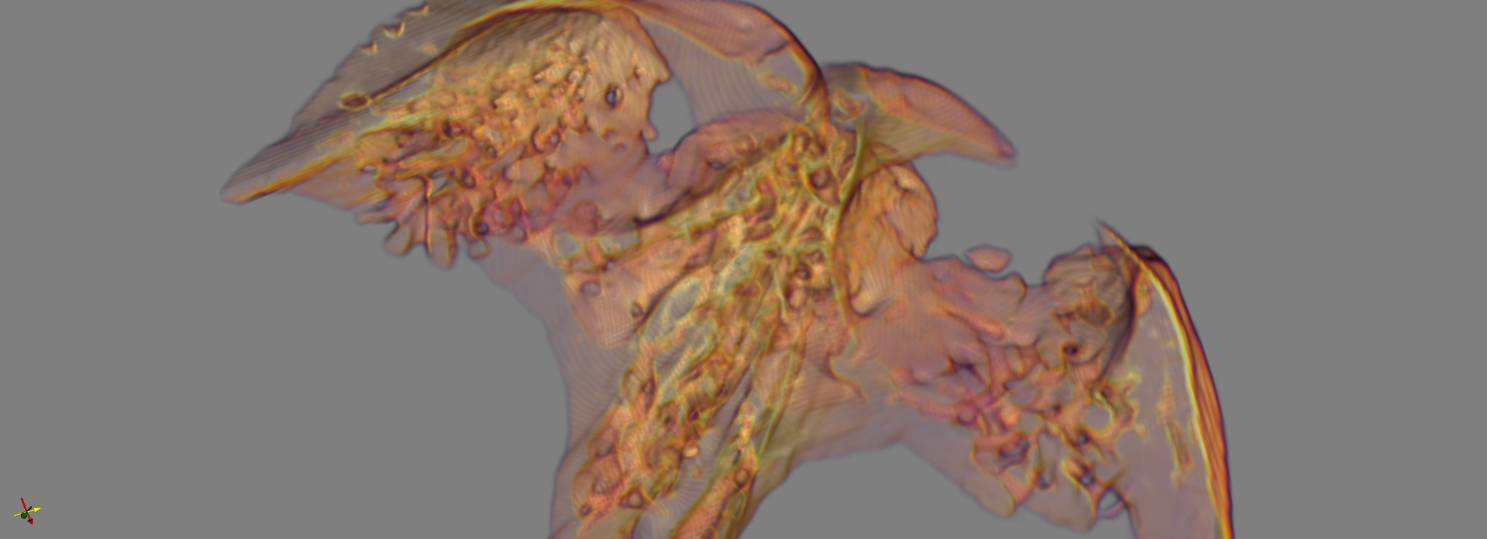
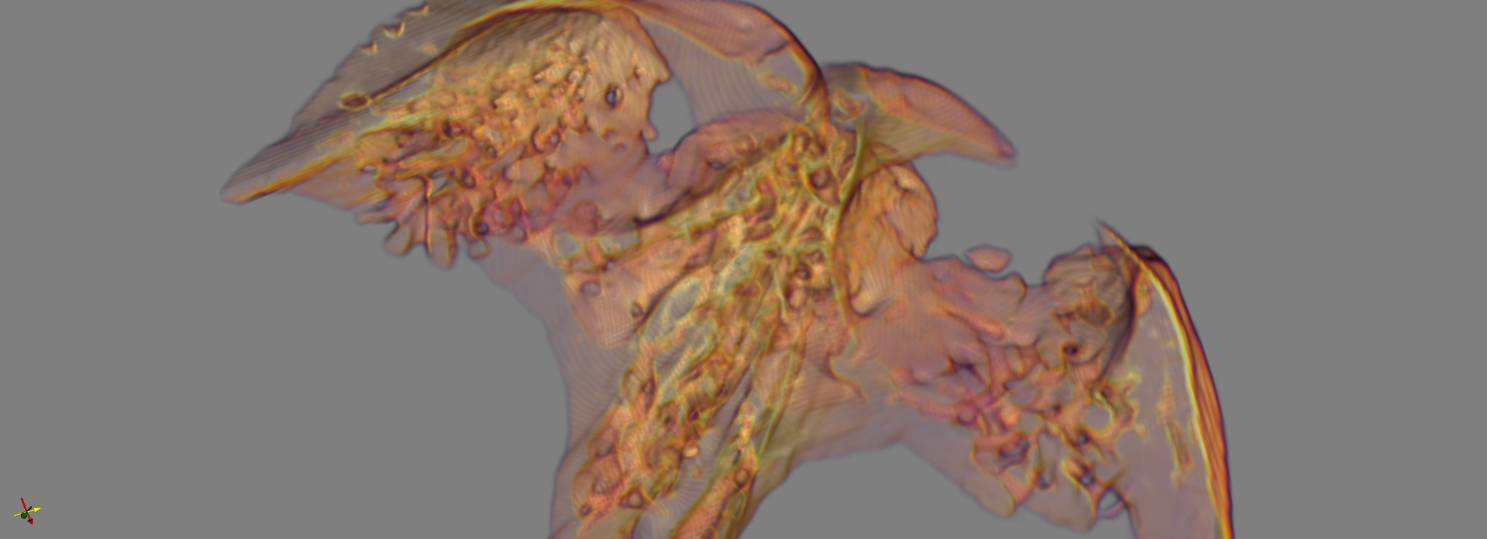

<IPython.core.display.Javascript object>

In [35]:
median_multiscales = from_ngff_zarr(zarr_store)

view(median_multiscales)

## Apply filters that require an extended information context

Some filters may required an extended domain of local information. In this case, special algorithms may be required to perform distributed, out-of-core processing.

The [dask-image](https://image.dask.org/) library has implementations of distributed algorithms.

Let's try connected components as an example.

In [57]:
binary_thresholder = lambda i: (i > 80).astype(np.uint8)

# We will threshold the median-filtered image
thresholded = median_multiscales.images[0].data.map_blocks(binary_thresholder)

connected_components, num_components = dask_image.ndmeasure.label(thresholded)

connected_components

dask.array<getitem, shape=(221, 479, 423), dtype=int32, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

*662 graph layers* - more steps are required.

In [60]:
full_res_connected = copy(full_res)
full_res_connected.data = connected_components.astype(np.uint8)

We use `Methods.ITKWASM_LABEL_IMAGE` for multiscale generation because the input is a label image.

In [61]:
multiscales = to_multiscales(full_res_connected, method=Methods.ITKWASM_LABEL_IMAGE)
zarr_store = zarr.DirectoryStore("./connected_roi.zarr", dimension_separator="/")
to_ngff_zarr(zarr_store, multiscales)
connected_multiscales = from_ngff_zarr(zarr_store)
print(connected_multiscales)

Multiscales(
    images=[
        NgffImage(
            data=dask.array<from-zarr, shape=(221, 479, 423), dtype=uint8, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=['z', 'y', 'x'],
            scale={'z': 1.0, 'y': 1.0, 'x': 1.0},
            translation={'z': -0.5, 'y': -0.5, 'x': -0.5},
            name='image',
            axes_units={'z': None, 'y': None, 'x': None},
            computed_callbacks=[]
        ),
        NgffImage(
            data=dask.array<from-zarr, shape=(221, 239, 211), dtype=uint8, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=['z', 'y', 'x'],
            scale={'z': 1.0, 'y': 2.0, 'x': 2.0},
            translation={'z': -0.5, 'y': 0.0, 'x': 0.0},
            name='image',
            axes_units={'z': None, 'y': None, 'x': None},
            computed_callbacks=[]
        )
    ],
    metadata=Metadata(
        axes=[
            Axis(name='z', type='space', unit=None),
            Axis(name='y', type='space', unit=None),
            Axis(name='x', type='space', unit=None)
        ],
        datasets=[
            Dataset(
                path='scale0/Image',
                coordinateTransformations=[
                    Scale(scale=[1.0, 1.0, 1.0], type='scale'),
                    Translation(translation=[-0.5, -0.5, -0.5], type='translation')
                ]
            ),
            Dataset(
                path='scale1/Image',
                coordinateTransformations=[
                    Scale(scale=[1.0, 2.0, 2.0], type='scale'),
                    Translation(translation=[-0.5, 0.0, 0.0], type='translation')
                ]
            )
        ],
        coordinateTransformations=None,
        name='image',
        version='0.4'
    ),
    scale_factors=None,
    method=None,
    chunks=None
)


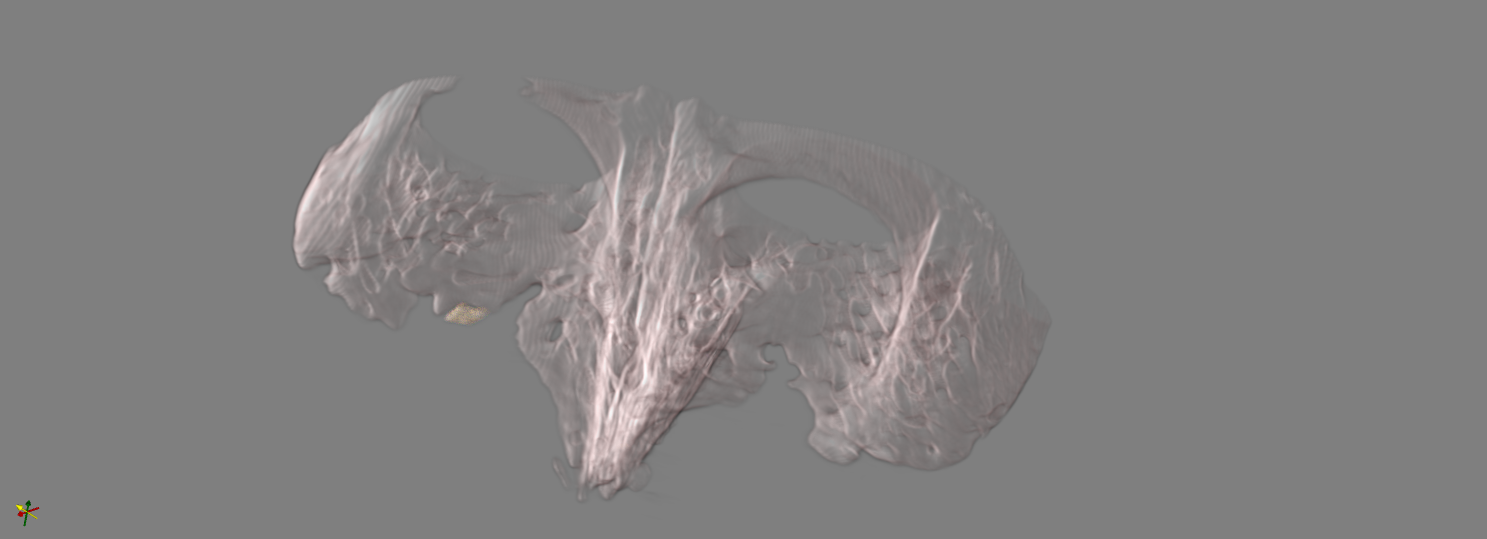
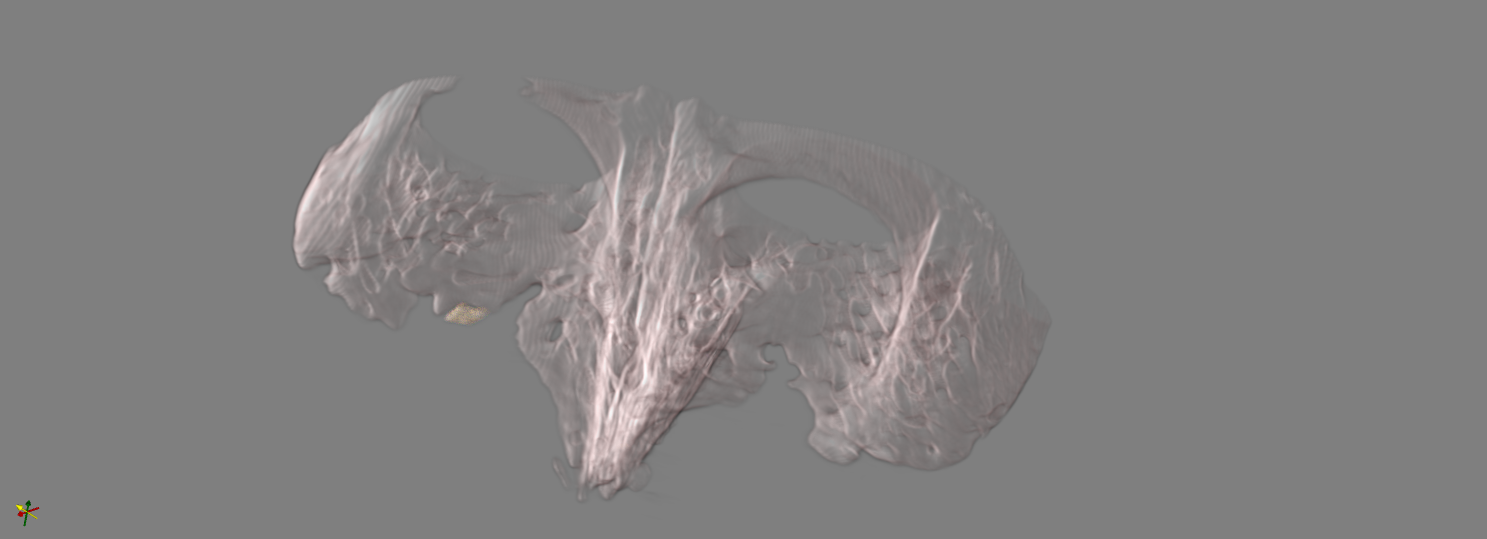

<IPython.core.display.Javascript object>

In [63]:
view(image=median_multiscales, label_image=connected_multiscales)

## Additional examples


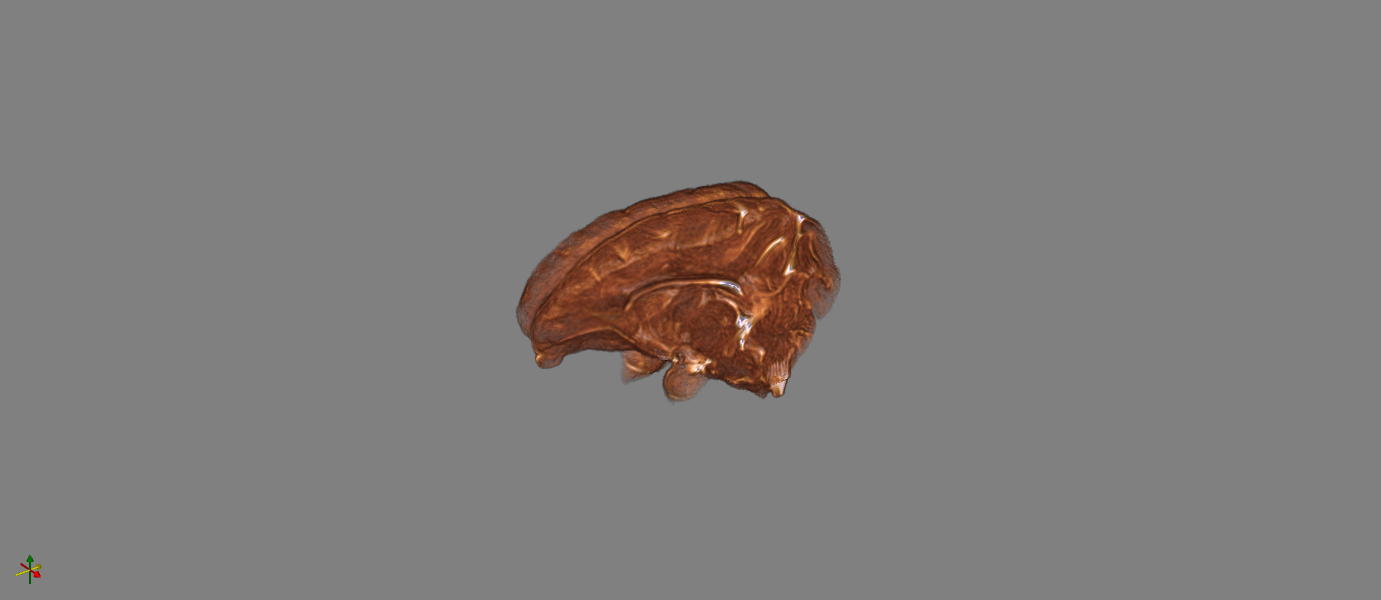
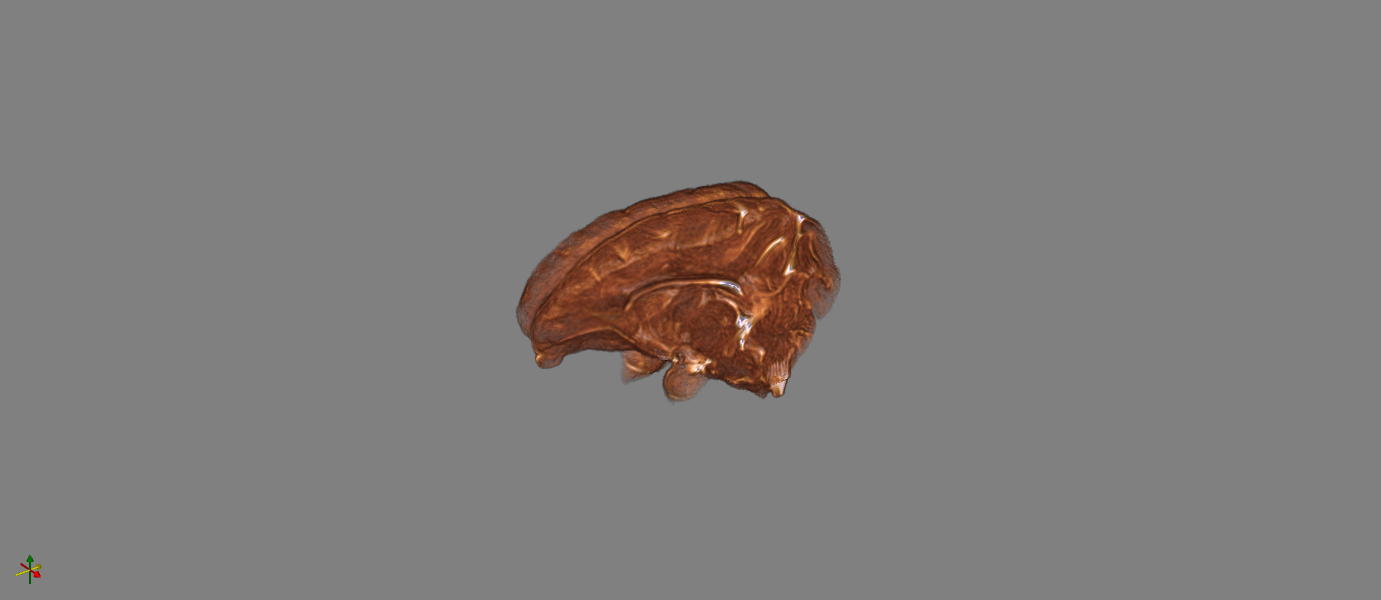

<IPython.core.display.Javascript object>

In [17]:
# bilateral filter

def apply(image_data, threshold=128):
    import itk
    result = itk.bil(image_data, lower_threshold=threshold)
    
    # convert to a numpy ndarray
    return np.asarray(result).copy()

threshold = 80

full_res = roi_multiscales.images[0]

# The first argument passed to apply_threshold will be the chunk numpy array
# dtype is the expected type of the result
new_data = full_res.data.map_blocks(apply_threshold, threshold)

new_data

In [3]:
imf = itk_image.astype(np.float32)
print(imf)

Image (0x5573996f6760)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 509
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 502
  UpdateMTime: 508
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [423, 479, 221]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [423, 479, 221]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [423, 479, 221]
  Spacing: [1, 1, 1]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1 0 0
0 1 0
0 0 1

  PointToIndexMatrix: 
1 0 0
0 1 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5573991cd5c0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 506
      Debug: Off
      Object Name: 
      Observers: 
        none
      Pointer: 0x7f62a0bc5010
      Container manages memory: true
      Size: 44778357
      Capacity: 44778357

In [ ]:
#result = itk.bilateral_image_filter(imf, domain_sigma=1.5, range_sigma=4.0, automatic_kernel_size=False, radius=6)
result = itk.bilateral_image_filter(imf)


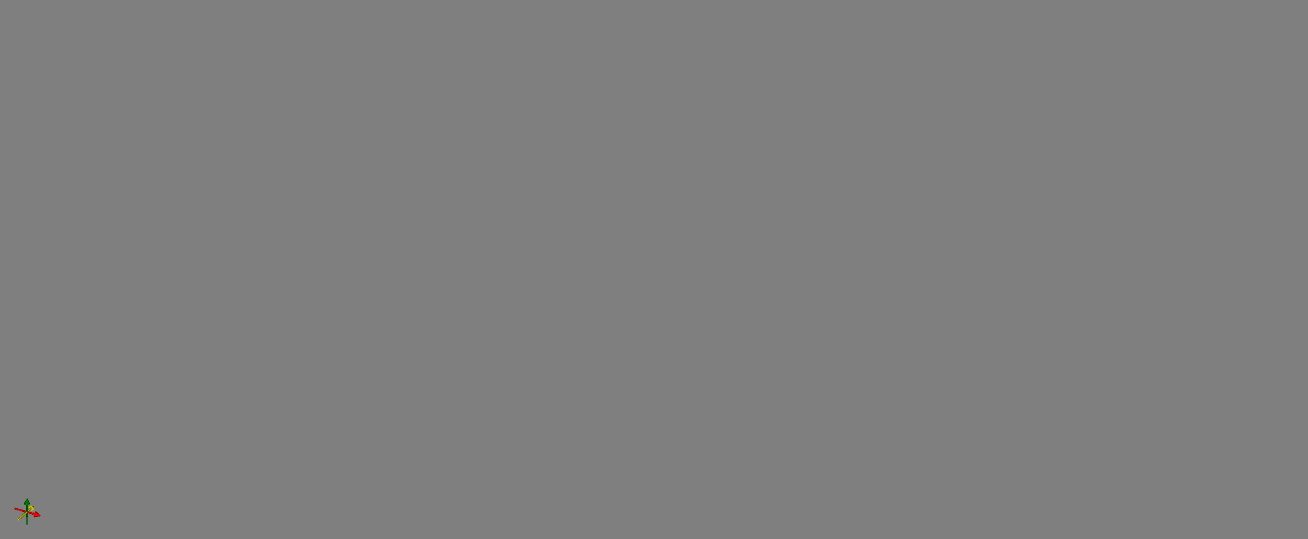
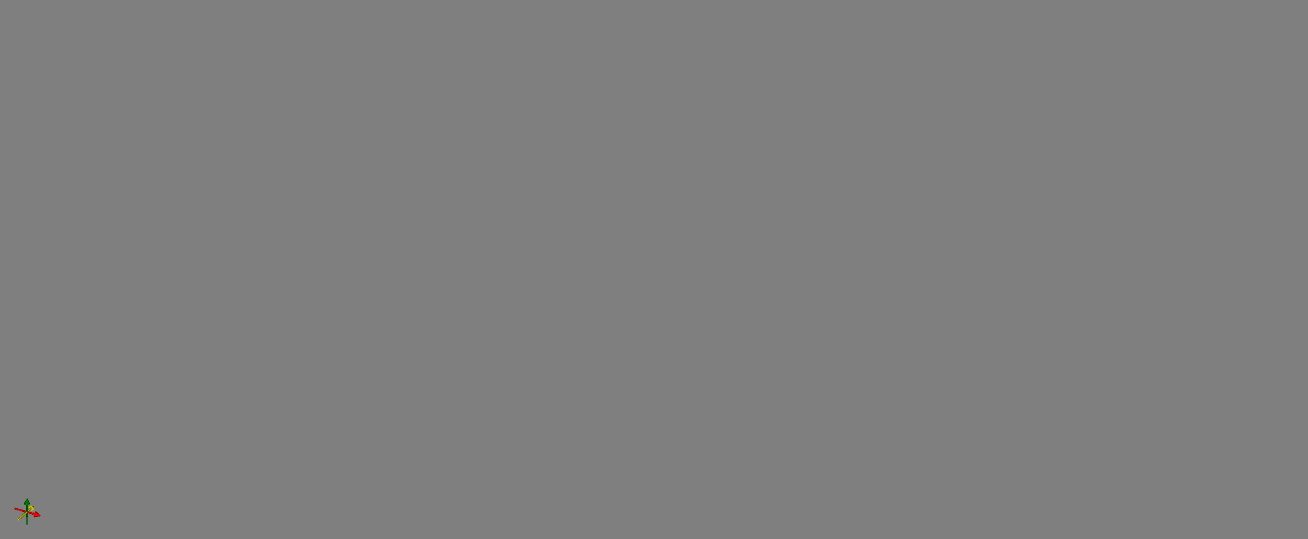

<IPython.core.display.Javascript object>

In [8]:
result = result.astype(np.uint8)
view(result)

In [4]:
np.min(result)

NameError: name 'result' is not defined

In [7]:
np.max(result)

255.0

In [5]:
np.max(imf)

255.0